In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import timm
from sklearn.model_selection import train_test_split

In [4]:

# Define a custom dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


In [5]:
# Define data directories
train_dir = "/content/gdrive/MyDrive/rnd1/week5/Training"  # Contains "utterances_d" and "utterances_nd" folders
test_dir = "/content/gdrive/MyDrive/rnd1/week5/Test"
# List of subfolders (class labels)
class_labels = [ "non_depressed","depressed"]

# List of time durations
# time_durations = ["25ms", "400ms"]

# Initialize lists to store file paths and labels
train_files = []
train_labels = []
test_files = []
test_labels = []


# Iterate through class labels and time durations to collect file paths and labels
for label in class_labels:
    # for duration in time_durations:
    folder_path = os.path.join(train_dir, label)
    file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    # Take a maximum of 100 images from each folder
    #file_paths = file_paths[:190]
    train_files.extend(file_paths)
    train_labels.extend([1 if label == "depressed" else 0] * len(file_paths))

for label in class_labels:
    # for duration in time_durations:
    folder_path = os.path.join(test_dir, label)
    file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    # Take a maximum of 100 images from each folder
    #file_paths = file_paths[:33]
    test_files.extend(file_paths)
    test_labels.extend([1 if label == "depressed" else 0] * len(file_paths))


In [6]:
# Define transformations for data augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
# Create dataset objects for training and validation
train_dataset = SpectrogramDataset(train_files, train_labels, transform=data_transforms)
test_dataset = SpectrogramDataset(test_files, test_labels, transform=data_transforms)

# Create data loaders
batch_size = 32
actual_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
actual_test_loader = DataLoader(test_dataset, batch_size=batch_size , shuffle=True)

In [8]:
# SMOTE + ENN Balancing Train Dataset
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# smenn=ADASYN(random_state=130)
smt=SMOTE()
X,Y=[],[]
for image,label in train_dataset:
    X.append(np.array(image.flatten()))
    Y.append(int(label))

P,Q=[],[]
for image,label in test_dataset:
    P.append(np.array(image.flatten()))
    Q.append(int(label))
# for image,label in test_dataset:
#     X.append(np.array(image.flatten()))
#     Y.append(int(label))


In [9]:

# X_balanced,Y_balanced = smenn.fit_resample(np.array(X),np.array(Y))
X_balanced,Y_balanced = smt.fit_resample(np.array(X),np.array(Y))
P_balanced,Q_balanced = smt.fit_resample(np.array(P),np.array(Q))


In [10]:
X_balanced = torch.from_numpy(X_balanced.reshape((len(X_balanced),3,224,224)))
P_balanced = torch.from_numpy(P_balanced.reshape((len(P_balanced),3,224,224)))


In [11]:
len(X_balanced)

384

In [12]:
X_train,X_eval,Y_train,Y_eval = train_test_split(X_balanced,Y_balanced,test_size=0.2,random_state=44)
# X_test,X_o,Y_test,Y_o = train_test_split(P_balanced,Q_balanced,test_size=0,random_state=44)


train_dataset=[(X_train[i].squeeze(),torch.tensor(Y_train[i])) for i in range(len(X_train))]
eval_dataset=[(X_eval[i].squeeze(),torch.tensor(Y_eval[i])) for i in range(len(X_eval))]
test_dataset=[(P_balanced[i].squeeze(),torch.tensor(Q_balanced[i])) for i in range(len(P_balanced))]



# train_dataset=[(X_balanced[i].squeeze(),torch.tensor(Y_balanced[i])) for i in range(len(X_balanced))]

# test_dataset=[(P_balanced[i].squeeze(),torch.tensor(Q_balanced[i])) for i in range(len(P_balanced))]


In [13]:
# print(X_eval.size())
# print(Y_eval.size())


In [14]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming X_train is a PyTorch tensor and Y_train is a NumPy array
# Convert Y_train to a PyTorch tensor
Y_train = torch.from_numpy(Y_train)

# Create a TensorDataset
train_data = TensorDataset(X_train, Y_train)
# Specify batch size for the DataLoader
batch_size = 16  # You can adjust this based on your requirements

# Create a DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [15]:
# Y_test = torch.from_numpy(Y_test)
# test_data = TensorDataset(X_test, Y_test)
batch_size = 16  # You can adjust this based on your requirements
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)


In [16]:
# Calculate class weights for the loss function
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()
print(class_weights)
# Load the MLP-Mixer model
model_name = "timm/convmixer_768_32.in1k"
model = timm.create_model(model_name, pretrained=True, num_classes=2)  # Change num_classes to 2 for binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


tensor([0.6484, 2.1842], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/84.9M [00:00<?, ?B/s]

In [17]:
# Combined model

# # Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate weighted loss for each example in the batch
        batch_class_weights = torch.tensor([1, 1], dtype=torch.float32).to(device)

        # Calculate weighted loss for each example in the batch
        weighted_loss = loss * batch_class_weights[labels]

        # Compute the mean of the weighted losses in the batch
        mean_weighted_loss = weighted_loss.mean()

        mean_weighted_loss.backward()
        optimizer.step()

        running_loss += mean_weighted_loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    training_accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Training Accuracy: {training_accuracy}")


Epoch 1/15, Loss: 0.6639857441186905, Training Accuracy: 0.6351791530944625
Epoch 2/15, Loss: 0.5591727957129479, Training Accuracy: 0.8338762214983714
Epoch 3/15, Loss: 0.38499039113521577, Training Accuracy: 0.8892508143322475
Epoch 4/15, Loss: 0.1838253602385521, Training Accuracy: 0.9706840390879479
Epoch 5/15, Loss: 0.10771360266953707, Training Accuracy: 0.9706840390879479
Epoch 6/15, Loss: 0.10335503248497843, Training Accuracy: 0.993485342019544
Epoch 7/15, Loss: 0.05520938243716955, Training Accuracy: 0.9869706840390879
Epoch 8/15, Loss: 0.0628767266869545, Training Accuracy: 0.990228013029316
Epoch 9/15, Loss: 0.02223542593419552, Training Accuracy: 1.0
Epoch 10/15, Loss: 0.032004015269922095, Training Accuracy: 0.993485342019544
Epoch 11/15, Loss: 0.02684449507505633, Training Accuracy: 0.993485342019544
Epoch 12/15, Loss: 0.02060829002293758, Training Accuracy: 1.0
Epoch 13/15, Loss: 0.017911502515198664, Training Accuracy: 0.996742671009772
Epoch 14/15, Loss: 0.02007824547

In [18]:
# Evaluate the model on the train set
from sklearn.metrics import classification_report, accuracy_score
def result(data_loader , title = ""):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"{title} Accuracy: {accuracy}")

    # Generate classification report
    report = classification_report(all_labels, all_preds)
    print("Classification Report:\n", report)

    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    # Calculate and print the confusion matrix
    confusion = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(confusion)

    # Plot the confusion matrix (optional)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Depressed", "Depressed"], yticklabels=["Non-Depressed", "Depressed"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

train_loader  Accuracy: 0.9837133550488599
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       161
           1       0.99      0.98      0.98       146

    accuracy                           0.98       307
   macro avg       0.98      0.98      0.98       307
weighted avg       0.98      0.98      0.98       307

Confusion Matrix:
[[159   2]
 [  3 143]]


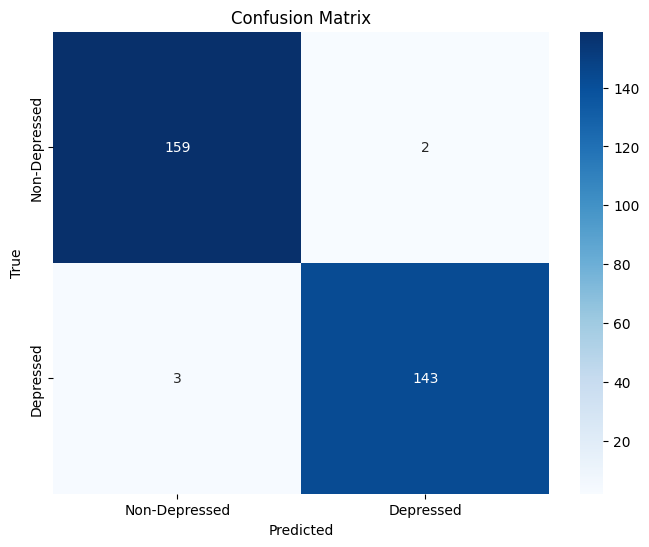

In [19]:
result(train_loader ,"train_loader ")

test_loader  Accuracy: 0.7064676616915423
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.81      0.73       201
           1       0.76      0.60      0.67       201

    accuracy                           0.71       402
   macro avg       0.72      0.71      0.70       402
weighted avg       0.72      0.71      0.70       402

Confusion Matrix:
[[163  38]
 [ 80 121]]


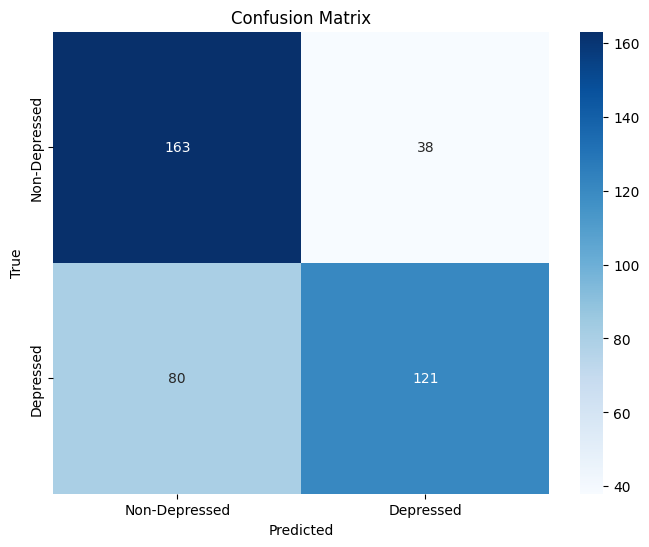

In [20]:
result(test_loader,'test_loader ')

actual_train_loader  Accuracy: 0.9196787148594378
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       192
           1       0.84      0.81      0.82        57

    accuracy                           0.92       249
   macro avg       0.89      0.88      0.88       249
weighted avg       0.92      0.92      0.92       249

Confusion Matrix:
[[183   9]
 [ 11  46]]


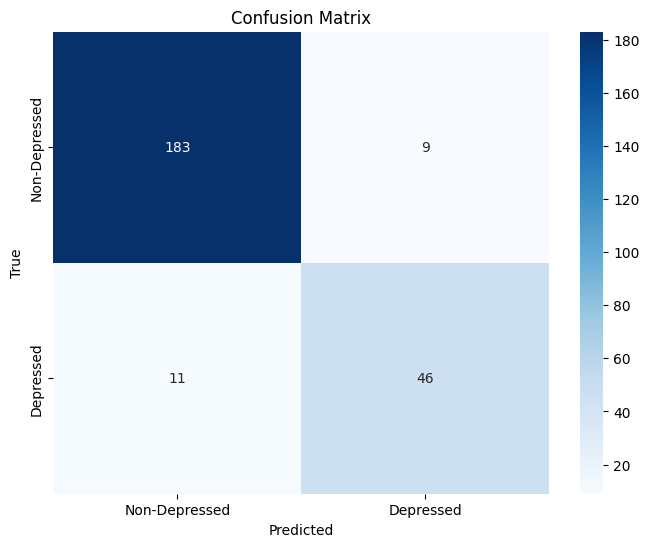

In [21]:
result(actual_train_loader,'actual_train_loader ')

actual_test_loader  Accuracy: 0.7435897435897436
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       201
           1       0.19      0.24      0.21        33

    accuracy                           0.74       234
   macro avg       0.53      0.53      0.53       234
weighted avg       0.77      0.74      0.76       234

Confusion Matrix:
[[166  35]
 [ 25   8]]


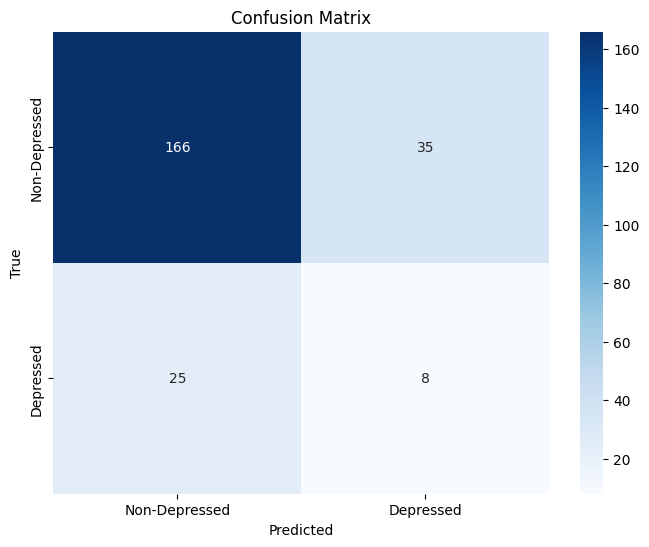

In [22]:
result(actual_test_loader,'actual_test_loader ')


eval_loader Accuracy: 0.922077922077922
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.92      0.96      0.94        46

    accuracy                           0.92        77
   macro avg       0.92      0.91      0.92        77
weighted avg       0.92      0.92      0.92        77

Confusion Matrix:
[[27  4]
 [ 2 44]]


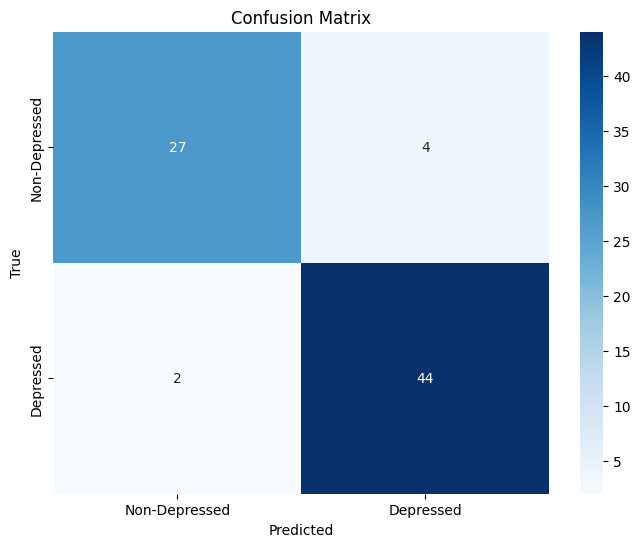

In [23]:
result(eval_loader,'eval_loader')